Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [41]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from glob import glob

In [42]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [43]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("gdrive/My Drive/Upgrad/Lab/01_Melanoma_Detection_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('gdrive/My Drive/Upgrad/Lab/01_Melanoma_Detection_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [44]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Dataset creation

Define some parameters for the loader:

In [45]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [48]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
            data_dir_train,
            batch_size=batch_size,
            image_size=(img_height, img_width),
            seed=123,
            validation_split=0.2,
            subset='training',
            )

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [49]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
            data_dir_train,
            batch_size=batch_size,
            image_size=(img_height, img_width),
            seed=123,
            validation_split=0.2,
            subset='validation',
            )

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [50]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

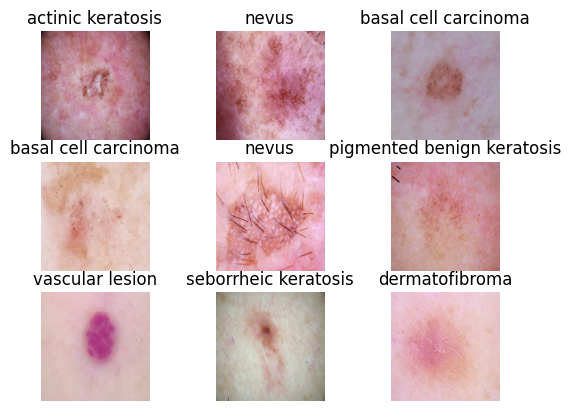

In [51]:
#import matplotlib.pyplot as plt
for i in range(len(class_names)):
    filtered_ds = train_ds.filter(lambda x, l: tf.math.equal(l[0], i))
    for image, label in filtered_ds.take(1):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(class_names[label.numpy()[i]])
        plt.axis('off')

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [52]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [53]:
#The Keras sequence class helps create a layer cluster that is linearly stacked into a tf. keras. Model.
num_class = 9
model = tf.keras.Sequential([
    layers.Rescaling(scale = 1./255, input_shape = (180,180,3)),
    layers.Conv2D(16,3,padding='same',activation= 'relu'),
    layers.MaxPooling2D(pool_size = 2, strides = 2),
    layers.Conv2D(32,3,padding='same',activation= 'relu'),
    layers.MaxPooling2D(pool_size = 2, strides = 2),
    layers.Conv2D(64,3,padding='same',activation= 'relu'),
    layers.MaxPooling2D(pool_size = 2, strides = 2),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(num_class)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [54]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

In [55]:
# View the summary of all layers
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 45, 45, 64)       

### Train the model

In [56]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 28s 171ms/step - loss: 1.9780 - accuracy: 0.2729 - val_loss: 1.7283 - val_accuracy: 0.3893
Epoch 2/20
56/56 [==============================] - 1s 22ms/step - loss: 1.7089 - accuracy: 0.3962 - val_loss: 2.0111 - val_accuracy: 0.3020
Epoch 3/20
56/56 [==============================] - 1s 20ms/step - loss: 1.4981 - accuracy: 0.4799 - val_loss: 1.4736 - val_accuracy: 0.5123
Epoch 4/20
56/56 [==============================] - 1s 21ms/step - loss: 1.3910 - accuracy: 0.5201 - val_loss: 1.5401 - val_accuracy: 0.4855
Epoch 5/20
56/56 [==============================] - 1s 25ms/step - loss: 1.3142 - accuracy: 0.5402 - val_loss: 1.3541 - val_accuracy: 0.5369
Epoch 6/20
56/56 [==============================] - 1s 25ms/step - loss: 1.2379 - accuracy: 0.5642 - val_loss: 1.4206 - val_accuracy: 0.5213
Epoch 7/20
56/56 [==============================] - 1s 21ms/step - loss: 1.1767 - accuracy: 0.5725 - val_loss: 1.3875 - val_accuracy: 0.5459
Epoch 8/20


### Visualizing training results

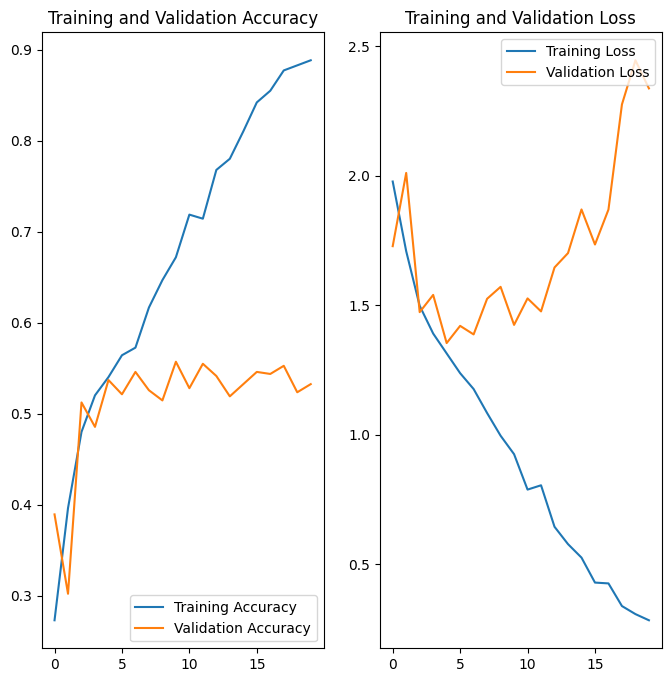

In [57]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

<h2>Findings:-</h2>

<p style="font-size:18px"> The above model is clearly the case of overfitting and the model doesn't seem to be learning anything from the dataset:<br> </p>
<br>
1. Training accuracy is very high around 88%, while validation accuracy is around 50%. <br>
2. The loss on the training set decreases after each epoch, but in the case of the validation set, it climbs back again after the 5th epoch and mostly keep on increasing till 20th epoch. <br>

<p style="font-size:18px">
<br>
Instead of generalizing and learning real features and general relationships, it seems the model memorized the data. This is clear case of overfit model.</p>

In [59]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomZoom(height_factor=(0.2,0.3), width_factor=(0.2,0.3))
])

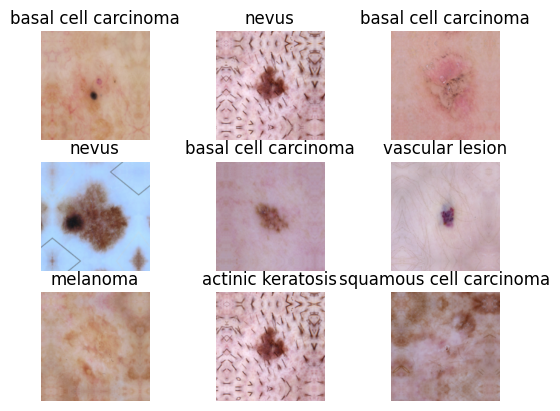

In [60]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
for img, labels in train_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(data_augmentation(img)[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [64]:
## Using Dropout layer since there is clear evidence of overfitting in the above model
num_classes = 9
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.25),
  layers.Dense(num_classes)
])


### Compiling the model

In [65]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

### Training the model

In [66]:
## Training the model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 4s 34ms/step - loss: 2.1238 - accuracy: 0.1948 - val_loss: 1.9836 - val_accuracy: 0.2841
Epoch 2/20
56/56 [==============================] - 2s 33ms/step - loss: 1.7988 - accuracy: 0.3510 - val_loss: 1.6264 - val_accuracy: 0.4497
Epoch 3/20
56/56 [==============================] - 2s 37ms/step - loss: 1.6000 - accuracy: 0.4397 - val_loss: 1.5101 - val_accuracy: 0.4810
Epoch 4/20
56/56 [==============================] - 2s 30ms/step - loss: 1.5410 - accuracy: 0.4615 - val_loss: 1.5007 - val_accuracy: 0.4966
Epoch 5/20
56/56 [==============================] - 2s 31ms/step - loss: 1.4862 - accuracy: 0.4933 - val_loss: 1.4853 - val_accuracy: 0.4989
Epoch 6/20
56/56 [==============================] - 2s 32ms/step - loss: 1.4253 - accuracy: 0.5061 - val_loss: 1.4349 - val_accuracy: 0.5213
Epoch 7/20
56/56 [==============================] - 2s 30ms/step - loss: 1.4451 - accuracy: 0.4983 - val_loss: 1.4868 - val_accuracy: 0.4966
Epoch 8/20
56

### Visualizing the results

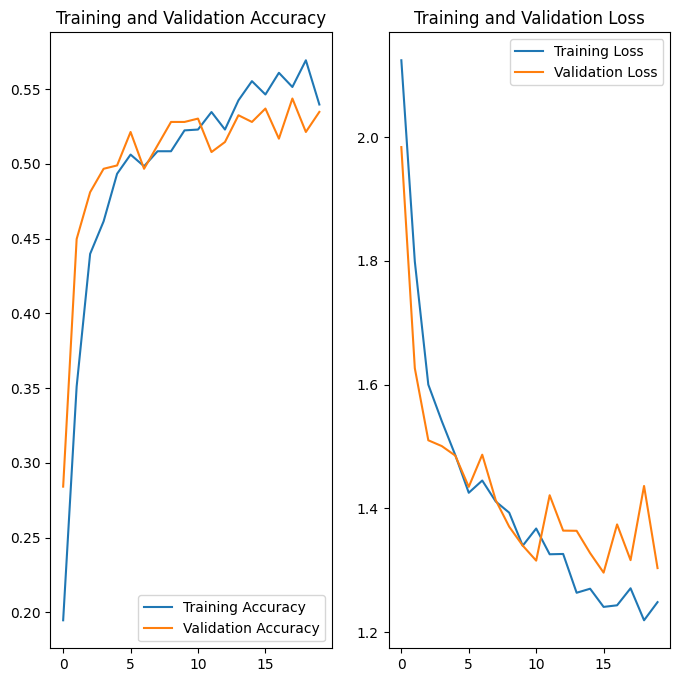

In [67]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

<h2>Findings:-</h2>
<p style="font-size:18px"> In the above model use of data augmentation and dropout layer reduced the problem of overfitting. <br/>
    <br/>The accuracy of the model has greatly increased along with the synchronization of the verification accuracy. The loss function is synchronously exhausted for the training and validation data.</p>

#### **Todo:** Find the distribution of classes in the training dataset.

#### Class distribution

In [68]:
## original_df - > path_list, lesion_list
path_list=[]
lesion_list=[]

In [69]:
for i in class_names:
  for j in data_dir_train.glob(i+'/*.jpg'):
    path_list.append(str(j))
    lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns=['Path','Label'])
original_df

,Path,Label
0,gdrive/My Drive/Upgrad/Lab/01_Melanoma_Detecti...,actinic keratosis
1,gdrive/My Drive/Upgrad/Lab/01_Melanoma_Detecti...,actinic keratosis
2,gdrive/My Drive/Upgrad/Lab/01_Melanoma_Detecti...,actinic keratosis
3,gdrive/My Drive/Upgrad/Lab/01_Melanoma_Detecti...,actinic keratosis
4,gdrive/My Drive/Upgrad/Lab/01_Melanoma_Detecti...,actinic keratosis
...,...,...
2234,gdrive/My Drive/Upgrad/Lab/01_Melanoma_Detecti...,vascular lesion
2235,gdrive/My Drive/Upgrad/Lab/01_Melanoma_Detecti...,vascular lesion
2236,gdrive/My Drive/Upgrad/Lab/01_Melanoma_Detecti...,vascular lesion
2237,gdrive/My Drive/Upgrad/Lab/01_Melanoma_Detecti...,vascular lesion


<BarContainer object of 9 artists>

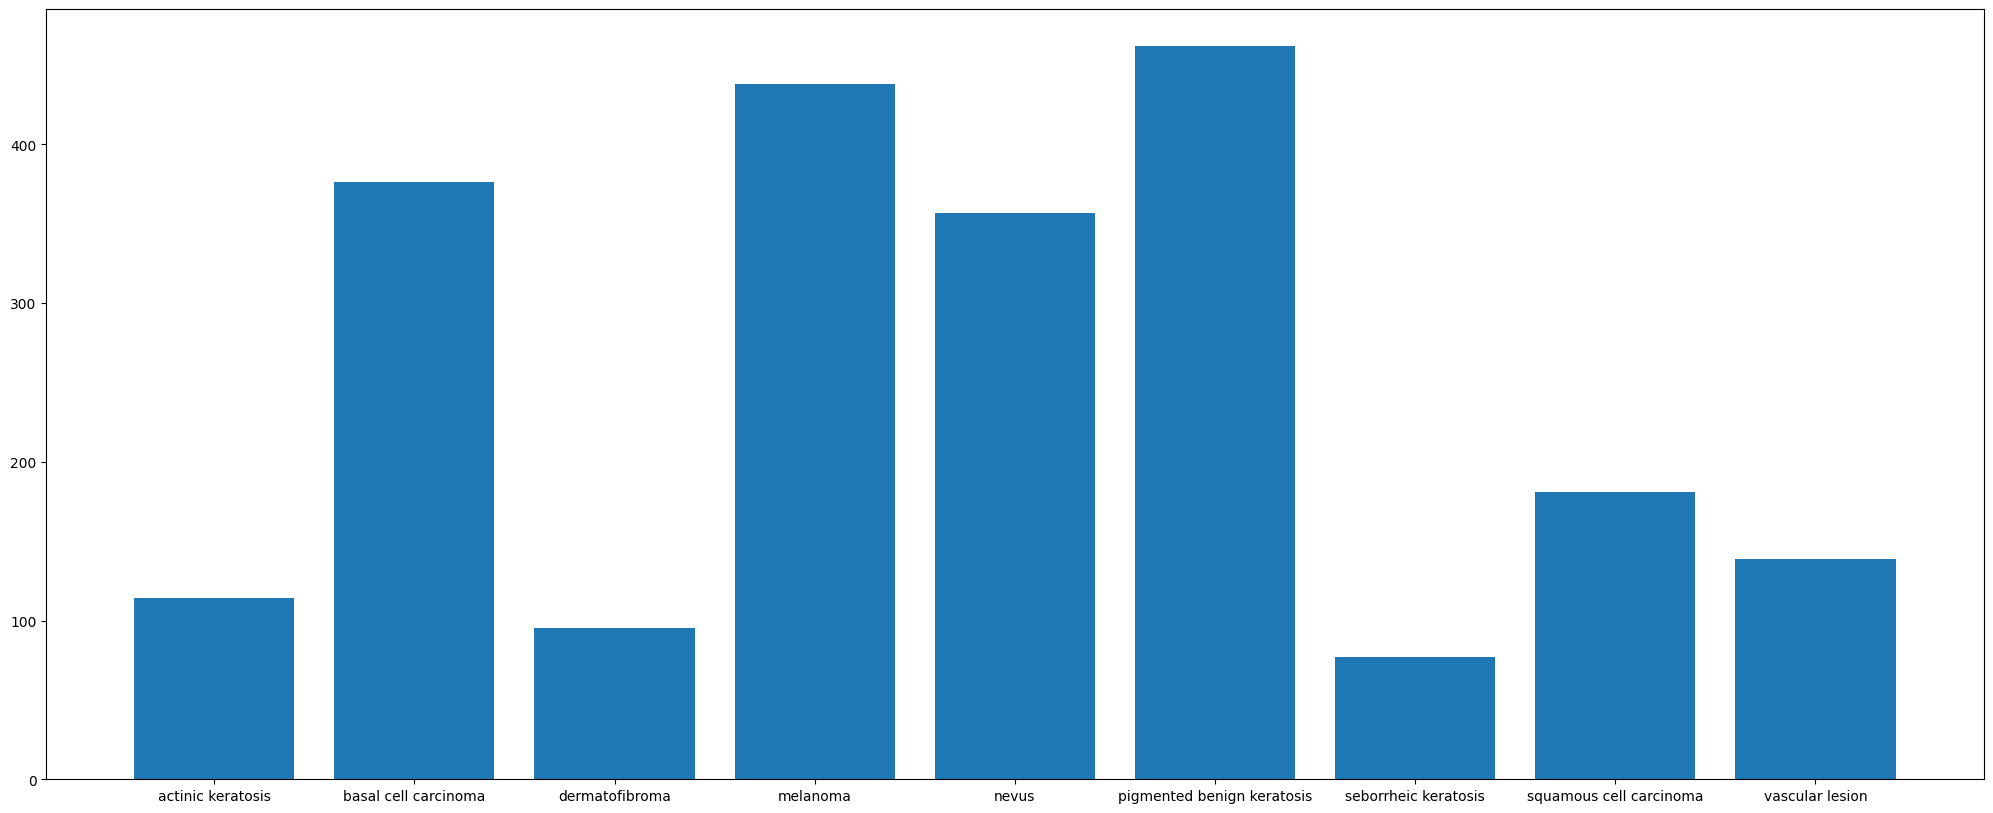

In [70]:
# glob('./Skin cancer ISIC The International Skin Imaging Collaboration/train/*/*')
# './Skin cancer ISIC The International Skin Imaging Collaboration/train\\actinic keratosis\\ISIC_0025780.jpg'
class_count=[]
for i in class_names:
    class_count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,class_count)

#### - Which class has the least number of samples?
<p syle="size:18px">The least number of samples are in seborrheic keratosis</p><br>

#### - Which classes dominate the data in terms proportionate number of samples?
<p syle="size:18px">The classes dominate in the data are:-


1.   pigmented benign keratosis
2.   melanoma
3.   basal cell carcinoma
4.   nevus
 </p>


#### Handling class imbalances
#### Using python package as `Augmentor` to add more samples across all classes so that none of the classes have very few samples.

In [71]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [72]:
import Augmentor
import os

path_to_training_dataset="/content/gdrive/MyDrive/Upgrad/Lab/01_Melanoma_Detection_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train"

for i in class_names:
    # Use os.path.join to create the correct directory path
    full_path = os.path.join(path_to_training_dataset, i)

    # Check if the directory exists before creating the pipeline
    if os.path.exists(full_path):
        p = Augmentor.Pipeline(full_path)
        p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
        p.sample(500)  # We are adding 500 samples per class
    else:
        print(f"Directory not found: {full_path}")

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/Lab/01_Melanoma_Detection_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E98E00B5C90>: 100%|██████████| 500/500 [00:27<00:00, 18.35 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/Lab/01_Melanoma_Detection_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E98DE604F10>: 100%|██████████| 500/500 [00:22<00:00, 22.15 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/Lab/01_Melanoma_Detection_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E9964145510>: 100%|██████████| 500/500 [00:19<00:00, 25.93 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/Lab/01_Melanoma_Detection_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E98DE604760>: 100%|██████████| 500/500 [01:26<00:00,  5.75 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/Lab/01_Melanoma_Detection_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E98DE4CBEE0>: 100%|██████████| 500/500 [01:26<00:00,  5.78 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/Lab/01_Melanoma_Detection_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E98DE671000>: 100%|██████████| 500/500 [00:19<00:00, 25.10 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/Lab/01_Melanoma_Detection_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E98E0489A80>: 100%|██████████| 500/500 [00:40<00:00, 12.25 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/Lab/01_Melanoma_Detection_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E98E0394070>: 100%|██████████| 500/500 [00:24<00:00, 20.33 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/Lab/01_Melanoma_Detection_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E99641455D0>: 100%|██████████| 500/500 [00:21<00:00, 23.21 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [73]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


#### See the distribution of augmented data after adding new images to the original training data

In [74]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['gdrive/My Drive/Upgrad/Lab/01_Melanoma_Detection_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026496.jpg_a5320343-cd68-4957-80a8-bb4d07ae6d9a.jpg',
 'gdrive/My Drive/Upgrad/Lab/01_Melanoma_Detection_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031063.jpg_b3288c61-6e48-482e-a1f2-2abaf0d99c8a.jpg',
 'gdrive/My Drive/Upgrad/Lab/01_Melanoma_Detection_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027704.jpg_726d1c21-51ff-4aae-b0b4-306ac0a4927d.jpg',
 'gdrive/My Drive/Upgrad/Lab/01_Melanoma_Detection_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031450.jpg_e0a70f56-594f-455d-823d-c21edb7c7c9d.jpg',
 'gdrive

In [75]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',


In [76]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [77]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([original_df, df2], ignore_index=True)

In [78]:
new_df['Label'].value_counts()

Label
pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [79]:
batch_size = 32
img_height = 180
img_width = 180

####  Create a training dataset

In [80]:
data_dir_train="/content/gdrive/MyDrive/Upgrad/Lab/01_Melanoma_Detection_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset =  'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


####  Create a validation dataset

In [81]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Model Building

In [82]:
num_classes = 9
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.25),
  layers.Dense(num_classes)
])

#### Compile model

In [83]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### Model Training

In [84]:
epochs = 30
history30 = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 47s 255ms/step - loss: 1.9544 - accuracy: 0.2411 - val_loss: 1.7050 - val_accuracy: 0.3430
Epoch 2/30
169/169 [==============================] - 47s 269ms/step - loss: 1.6712 - accuracy: 0.3668 - val_loss: 1.4531 - val_accuracy: 0.4395
Epoch 3/30
169/169 [==============================] - 44s 247ms/step - loss: 1.5186 - accuracy: 0.4275 - val_loss: 1.4155 - val_accuracy: 0.4536
Epoch 4/30
169/169 [==============================] - 43s 246ms/step - loss: 1.4467 - accuracy: 0.4445 - val_loss: 1.3364 - val_accuracy: 0.4900
Epoch 5/30
169/169 [==============================] - 43s 246ms/step - loss: 1.4013 - accuracy: 0.4633 - val_loss: 1.3355 - val_accuracy: 0.4996
Epoch 6/30
169/169 [==============================] - 45s 259ms/step - loss: 1.3611 - accuracy: 0.4839 - val_loss: 1.3465 - val_accuracy: 0.4915
Epoch 7/30
169/169 [==============================] - 44s 251ms/step - loss: 1.3261 - accuracy: 0.4930 - val_loss: 1.3164 - val_ac

####  Visualize the model results

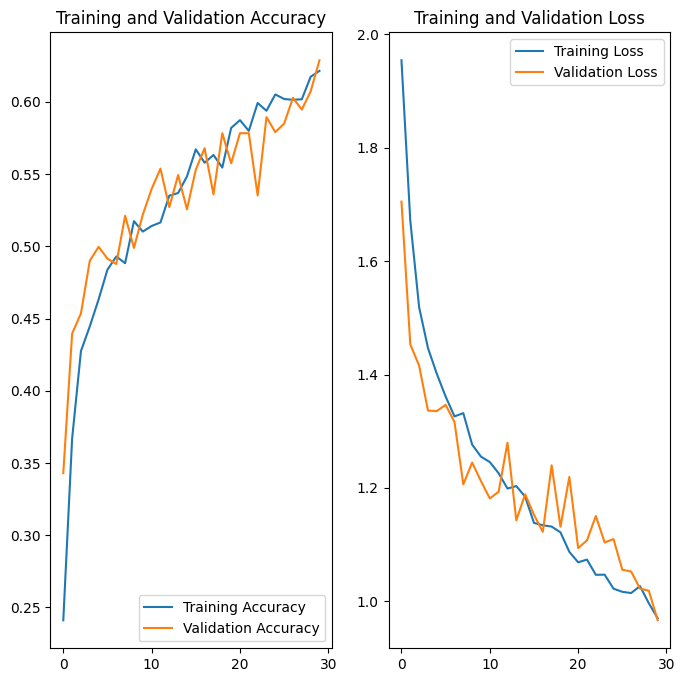

In [85]:
acc = history30.history['accuracy']
val_acc = history30.history['val_accuracy']

loss = history30.history['loss']
val_loss = history30.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



<p syle="size:18px">
Yes, the underfitting/overfitting has been removed.

1.  New model has training and validation accuracy on similar numbers around 62%.
2.   After 30 epochs, Training and Validation loss reduced on each epoch.
</p><br>

*** End of the file ***